In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from datetime import datetime

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objects as go
import plotly


mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

sns.set(style="darkgrid")

In [21]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0] 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
7558,Bangladesh,2020-03-08,3.0,3.0,NaN,NaN,NaN,NaN,0.018,0.018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,137.0,0.001,0.0,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59,0.632,NaN
7559,Bangladesh,2020-03-09,3.0,0.0,NaN,NaN,NaN,NaN,0.018,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,147.0,0.001,0.0,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59,0.632,NaN
7560,Bangladesh,2020-03-10,3.0,0.0,NaN,NaN,NaN,NaN,0.018,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,163.0,0.001,0.0,8.0,0.0,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59,0.632,NaN
7561,Bangladesh,2020-03-11,3.0,0.0,NaN,NaN,NaN,NaN,0.018,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,187.0,0.001,0.0,11.0,0.0,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59,0.632,NaN
7562,Bangladesh,2020-03-12,3.0,0.0,NaN,NaN,NaN,NaN,0.018,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,211.0,0.001,0.0,14.0,0.0,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59,0.632,NaN


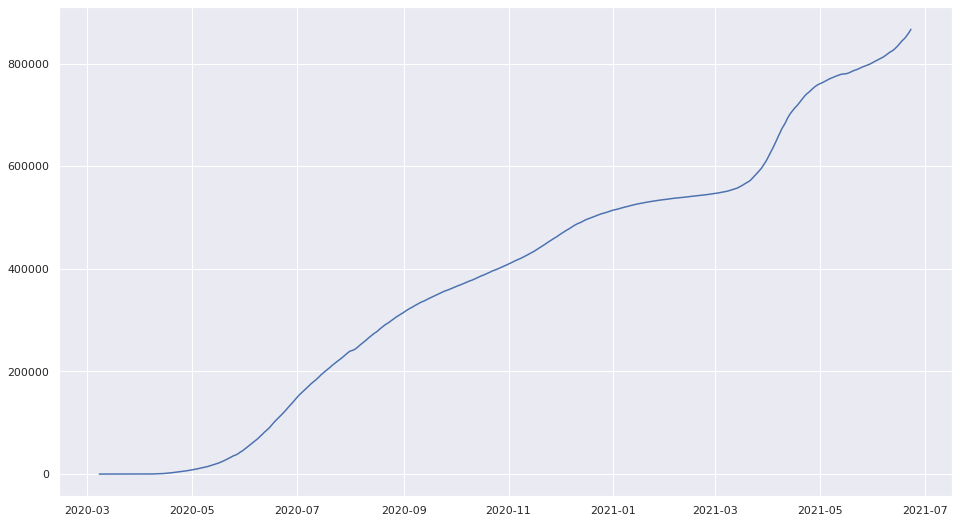

In [22]:
df=pd.read_csv('/content/drive/MyDrive/LSTM/Dataset/owid-covid-data.csv')
df1=df.loc[df['location']=='Bangladesh']
df1=df1.drop(['iso_code','continent'],axis=1)
df1=df1.dropna(subset=['new_cases'])
df_testdata=df1.reset_index()
df_testdata=df_testdata.drop(['index'],axis=1)
testdata_date=df_testdata['date'].astype('datetime64')
testdata_y=df_testdata['total_cases']
plt.plot(testdata_date,testdata_y)
df1.head()

In [23]:
testdata_y.shape

(473,)

In [24]:
testdata_y=np.array(testdata_y).reshape(-1,1)

In [25]:
##splitting dataset into train and test split
training_size=int(len(testdata_y)*0.95)
test_size=len(testdata_y)-training_size
train_data,test_data=testdata_y[0:training_size,:],testdata_y[training_size:len(df1),:1]

In [26]:
training_size,test_size

(449, 24)

In [27]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
X_train.shape,y_train.shape

((441, 7), (441,))

In [29]:
X_test.shape, ytest.shape

((16, 7), (16,))

In [30]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(10, activation='relu'))
model.add(Dense(1))
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse',optimizer=opt)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


In [33]:
history=model.fit(X_train,y_train, epochs=1000,batch_size=32,verbose=1)

Epoch 1/1000
14/14 [==============================] - 3s 8ms/step - loss: 166523682816.0000
Epoch 2/1000
14/14 [==============================] - 0s 7ms/step - loss: 76020752384.0000
Epoch 3/1000
14/14 [==============================] - 0s 8ms/step - loss: 1562445568.0000
Epoch 4/1000
14/14 [==============================] - 0s 8ms/step - loss: 1230288768.0000
Epoch 5/1000
14/14 [==============================] - 0s 8ms/step - loss: 182101248.0000
Epoch 6/1000
14/14 [==============================] - 0s 7ms/step - loss: 2655951360.0000
Epoch 7/1000
14/14 [==============================] - 0s 8ms/step - loss: 762082752.0000
Epoch 8/1000
14/14 [==============================] - 0s 8ms/step - loss: 34805895168.0000
Epoch 9/1000
14/14 [==============================] - 0s 8ms/step - loss: 34730659840.0000
Epoch 10/1000
14/14 [==============================] - 0s 8ms/step - loss: 3418198528.0000
Epoch 11/1000
14/14 [==============================] - 0s 8ms/step - loss: 5898580992.0000
Epoch

In [34]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [35]:
import math
from sklearn.metrics import mean_squared_error
train_error=math.sqrt(mean_squared_error(y_train,train_predict))
test_error=math.sqrt(mean_squared_error(ytest,test_predict))
print('\n train error', train_error)
print('\n test error', test_error)


 train error 7799.266062693826

 test error 3408.7299962384614


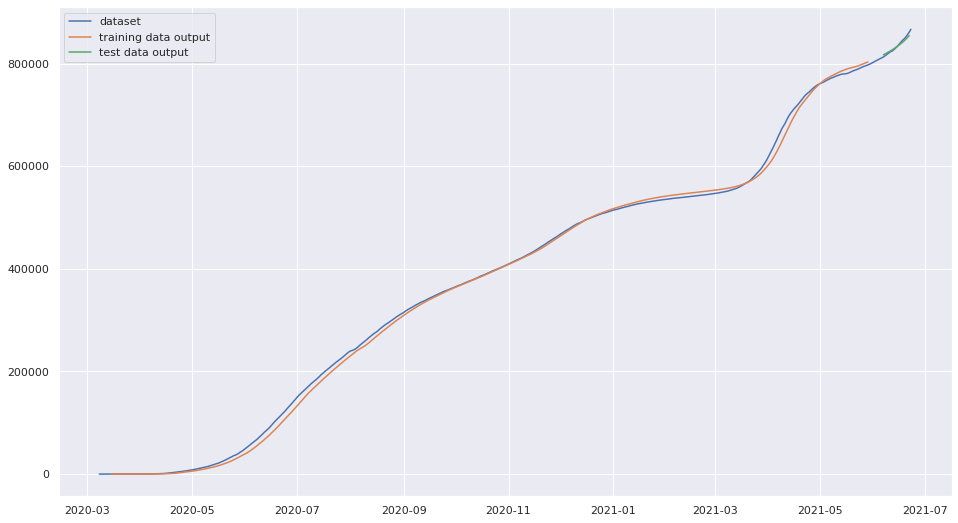

In [36]:
look_back=time_step
trainPredictPlot = numpy.empty_like(testdata_y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testdata_y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(testdata_y)-1, :] = test_predict

#plot baseline and predictions
plt.plot(testdata_date, testdata_y, label='dataset')
plt.plot(testdata_date, trainPredictPlot, label='training data output')
plt.plot(testdata_date, testPredictPlot, label='test data output')
plt.legend()
plt.show()


In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
mlp_mape = mean_absolute_percentage_error(ytest, test_predict)
mlp_mape

1.8109731170421277

In [39]:
#accuracy measurement
test_accuracy = 100 - mlp_mape
test_accuracy

98.18902688295788